# Exercise: Image Classification

In this exercise, we want to look at image classification using support vector machines. We will first use a simple data set from the hand segmentation to see how the SVM works, and then train a classifier on a larger data set of images.


We will use the SVM implementation from sklearn, which in turn uses the svm library.


In [3]:
import cv2
import os
import sys
import numpy as np
import sklearn

# for histogram of oriented gradients (hog)
from skimage.feature import hog

# we will use the svm from sklearn
from sklearn import svm

sys.path.append('.')
from cifar import load_cifar

# for displaying images in jupyter
import matplotlib as mpl
from matplotlib import pyplot as plt

from pathlib import Path
data_dir = Path('/exchange/cvai/images')

## Exercise 1: Hand / Background Segmentation

In the exercise in week 3, we have looked at segmenting the foreground (the hands) from a green background. We will now try to use machine learning for the same task. This is actual a task of semantic segmentation, as the classification is on pixel level which we will look at in more detail later in the lecture.

This is the image that we want to use for training. There is a similar image that we can use for testing.

(576, 864, 3)
(576, 864, 3)


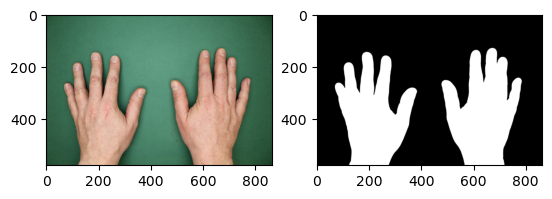

In [4]:
image  = cv2.imread(str(data_dir / 'hand_small.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = cv2.imread(str(data_dir / 'label_small.png'))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(label)
print(image.shape)
print(label.shape)

We would like to use 2D color features which should not contain the brightness. So we will convert the images to HSV and then use only hue and saturation channels. The SVM only needs an array or features, so we have to reshape it.

In [5]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hs = hsv[:,:,0:2]
data = hs.reshape((-1,2))
label_grey = label[:,:,0]
classes = label_grey.reshape(-1)

As now each pixel is a training example, the dataset is fairly large. We will reduce it by taking only every n-th pixel. You can try to lower n later, but training will take some time.

In [6]:
n = 50
classes_reduced = classes[1::n]
data_reduced = data[1::n,:]


We can plot the features (as they are 2D) to see how difficult a classification is.

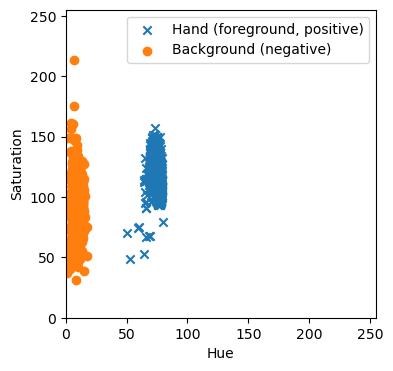

In [7]:
positives = data_reduced[classes_reduced==0]
negatives = data_reduced[classes_reduced==255]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(positives[:,0], positives[:,1], marker='x', label='Hand (foreground, positive)')
ax.scatter(negatives[:,0], negatives[:,1], marker='o', label='Background (negative)')
ax.set_xlabel('Hue'); ax.set_xlim([0, 255])
ax.set_ylabel('Saturation'); ax.set_ylim([0, 255])
ax.legend()

As you can see, it should be quite easy to train a linear classifier on this data set. We will now use the SM

In [8]:
classifier = svm.SVC(C=1.0, kernel='linear', gamma='auto')

In [9]:
classifier.fit(data_reduced, classes_reduced)

SVC(gamma='auto', kernel='linear')

We can apply the classifier to check the result. The score is the mean accuracy.

In [10]:
classifier.score(data_reduced,classes_reduced)

0.9898533252963633

Now load the second image and apply the same data reduction and calculate the score in a variable `score`.

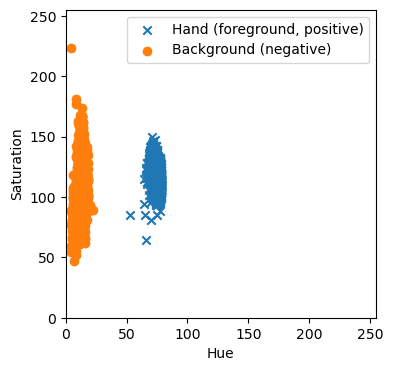

In [11]:
image2  = cv2.imread(str(data_dir /'hand_small_2.png'))
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
label2 = cv2.imread(str(data_dir / 'label_small_2.png'))
score = None

hsv = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)
hs = hsv[:,:,0:2]
data = hs.reshape((-1,2))
label_grey = label2[:,:,0]
classes = label_grey.reshape(-1)


classes_reduced = classes[1::n]
data_reduced = data[1::n,:]

positives = data_reduced[classes_reduced==0]
negatives = data_reduced[classes_reduced==255]

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(positives[:,0], positives[:,1], marker='x', label='Hand (foreground, positive)')
ax.scatter(negatives[:,0], negatives[:,1], marker='o', label='Background (negative)')
ax.set_xlabel('Hue'); ax.set_xlim([0, 255])
ax.set_ylabel('Saturation'); ax.set_ylim([0, 255])
ax.legend()

In [12]:
classifier = svm.SVC(C=1.0, kernel='linear', gamma='auto')
classifier.fit(data_reduced, classes_reduced)

SVC(gamma='auto', kernel='linear')

In [13]:
score = classifier.score(data_reduced,classes_reduced)
score

0.9876431585292345

In [14]:
np.testing.assert_allclose(score, 0.9, atol=0.1)

We have seen, that the score is not quite as good on the test image than on the training image.

If you like, you can also apply the classification to the whole image and then plot the result. However that will take a while to calculate.

## Exercise 2: Image Classification on CIFAR-10

We now want to classify images.

The data set that we use is the CIFAR data set. It contains 60000 small (32x32) images of 10 different classes of which 50000 are in the training set and 10000 in the test set. There is a version of the data set installed in the /home/data folder. We will use that, the utilities for loading the data are in the cifar.py file in the same directory.

In [15]:
cifar_path = data_dir / 'cifar-10-batches-py'
(x_image_train, y_train), (x_image_test, y_test) = load_cifar(cifar_path)
print(x_image_train.shape)
print(x_image_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


The following method will display some of the images and labels.

In [16]:
def show_images(images, labels):
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig, axes = plt.subplots(3, 5)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        example = np.random.randint(len(images))
        ax.imshow(images[example])
        
        # Name of the true class.
        cls_true_name = label_names[labels[example, 0]]
        xlabel = "{0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

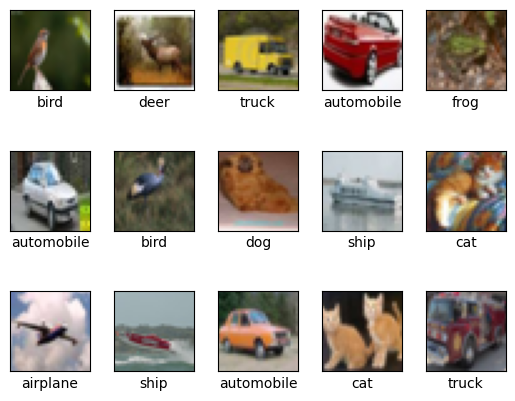

In [17]:
mpl.rcParams['figure.dpi']= 100
show_images(x_image_train, y_train)

We need image features as input. There are several possibilities, for example we could just use a color distribution. One of the best features are HOGs, histograms of oriented gradients another would be SIFT. We will use the HOG features in this example. Let us calculate the feature for one image and display it.

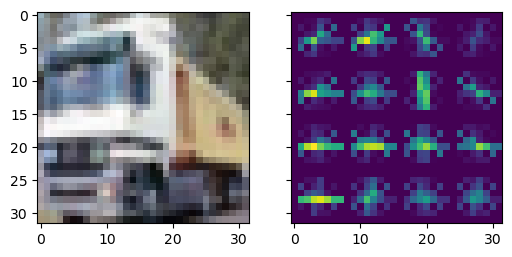

In [18]:
example_image = x_image_train[1]
example_hog, example_hog_image = hog(example_image, channel_axis=2, visualize=True)

_, axes = plt.subplots(1, 2, figsize=(6, 6), sharex=True, sharey=True)
axes[0].imshow(example_image)
axes[1].imshow(example_hog_image)
plt.show()

In [19]:
print(example_hog.shape)
print(example_hog)

(324,)
[0.11585298 0.07553268 0.11727471 0.12977551 0.14608267 0.03593609
 0.01165167 0.01209868 0.0178405  0.07430899 0.04148265 0.07351356
 0.24375984 0.19680555 0.05279726 0.0896438  0.02384095 0.11708333
 0.11020167 0.04277649 0.         0.01354401 0.02108305 0.06341896
 0.12316386 0.19396419 0.09735932 0.03461049 0.05492701 0.13202816
 0.1510649  0.24375984 0.03271795 0.02049885 0.02257968 0.02640008
 0.08505198 0.05066874 0.07065915 0.13159677 0.16886034 0.00290102
 0.12099924 0.06798503 0.09225834 0.24375984 0.07256034 0.01005707
 0.05995249 0.         0.00205133 0.01916322 0.05714728 0.24375984
 0.04453157 0.03502727 0.04191996 0.16091664 0.24375984 0.03687159
 0.00102192 0.02557856 0.07274151 0.07672771 0.04799608 0.02848091
 0.14660416 0.24375984 0.24375984 0.04455516 0.02474204 0.
 0.121097   0.02180994 0.08915554 0.10125904 0.17572328 0.20524307
 0.08197638 0.00854637 0.14550261 0.08127918 0.04537373 0.08040914
 0.24161515 0.21526593 0.05774965 0.0980524  0.02607723 0.12806

50000 images is a bit large, so we will start with a smaller data set of 10000 images randomly sampled from the full data set.

In [20]:
indices = np.random.choice(x_image_train.shape[0], 10000, replace=False)
x_image_train_small = x_image_train[indices, :, :, :]
y_train_small = y_train[indices, :]
print(x_image_train_small.shape)
print(y_train_small.shape)

(10000, 32, 32, 3)
(10000, 1)


We will now need the feature vectors of all images, define a function that calculate the hog features on an array of images and returns an array of feature vectors.

In [21]:
def calculate_features_hog(images):
    features = []

    for image in images:
        example_hog = hog(image, channel_axis=2, visualize=False)
        features.append(example_hog) 

    features_matrix = np.vstack(features)

    return features_matrix


In [22]:
features_train_small = calculate_features_hog(x_image_train_small)
features_train_small.shape

(10000, 324)

In [23]:
features_train_small = calculate_features_hog(x_image_train_small)
assert features_train_small.shape[0] == 10000
assert features_train_small.shape[1] == 324

In [29]:
features_train_small

array([[0.11586639, 0.11447066, 0.12946757, ..., 0.20914102, 0.09760403,
        0.0272905 ],
       [0.06198032, 0.04245343, 0.02667249, ..., 0.00674808, 0.        ,
        0.02690484],
       [0.00303727, 0.        , 0.00108474, ..., 0.01503973, 0.00159892,
        0.0036461 ],
       ...,
       [0.05242622, 0.07369295, 0.07806918, ..., 0.04106003, 0.04641578,
        0.11949296],
       [0.0485898 , 0.02081455, 0.03205974, ..., 0.08929216, 0.10103311,
        0.02123252],
       [0.00702   , 0.00229601, 0.01316975, ..., 0.04079352, 0.06797643,
        0.1338842 ]])

Now train a SVM classifier on that data set as above, again use a linear kernel.

In [30]:
classifier = None

data = features_train_small
classes = y_train_small.flatten()

classifier = svm.SVC(C=1.0, kernel='linear', gamma='auto')

classifier.fit(data, classes)

SVC(gamma='auto', kernel='linear')

In [31]:
# we will test the result by applying it to the first image, however 
# we can not really check the result, as it depends on the selection of data
result = classifier.predict([features_train_small[0]])
print(result)

[6]


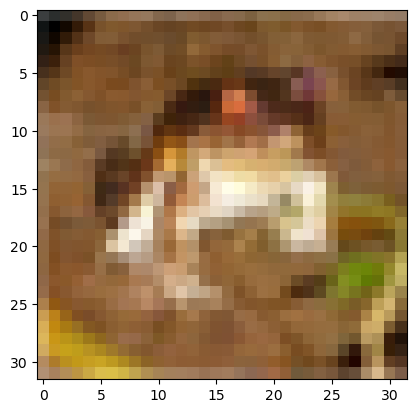

In [33]:
plt.imshow(x_image_train[0])

### Confusion matrix

In order to evaluate the result, we want to have a look at the confusion matrix which can be calculated using
 `sklearn.metrics.confusion_matrix`. Calculate the prediction and then the confusion matrix using the labels.

In [40]:
cm = None
# YOUR CODE HERE
predictions = classifier.predict(features_train_small)
y_train_small_predict = predictions
cm = sklearn.metrics.confusion_matrix(y_train_small, predictions)

In [41]:
assert cm.shape[0] == 10
assert cm.shape[1] == 10

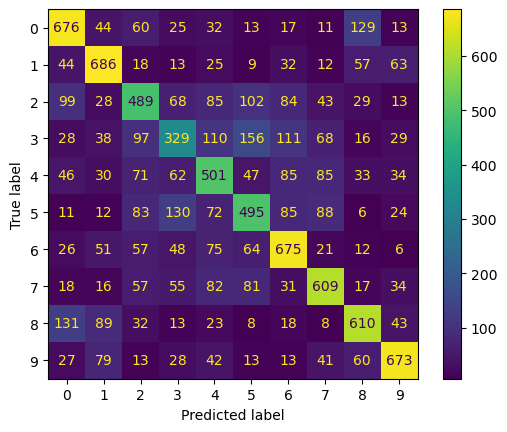

In [42]:
# there is also a display function for the matrix
disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()

For an overall assessment of the classifier, there is the function `sklearn.metrics.classification_report`.

In [43]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(sklearn.metrics.classification_report(y_train_small, y_train_small_predict, target_names=label_names))

              precision    recall  f1-score   support

    airplane       0.61      0.66      0.64      1020
  automobile       0.64      0.72      0.68       959
        bird       0.50      0.47      0.48      1040
         cat       0.43      0.34      0.38       982
        deer       0.48      0.50      0.49       994
         dog       0.50      0.49      0.50      1006
        frog       0.59      0.65      0.62      1035
       horse       0.62      0.61      0.61      1000
        ship       0.63      0.63      0.63       975
       truck       0.72      0.68      0.70       989

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000



### Optional further exercises
Of course we should evaluate the results on the test set instead, how does it look there? The results are not that good, can you change any parameters of the SVM to get better results?